# Machine Learning with PyTorch

## Tasks with Networks

* An image classifier
* A regression prediction
* Clustering with NNs (note: https://github.com/MarcTLaw/DeepSpectralClusteringToy)
* Generative Adversarial Networks (GAN)
* Reinforcement Learning

In [1]:
%matplotlib inline

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')
# Uncomment this to run on GPU
device = torch.device('cuda') 

torch.cuda.memory_allocated()

0

## Next Lesson

**Intermediate Machine Learning with PyTorch**: This last lesson of the Beginning material covered several real world neural networks.  For a deeper dive into some specialize areas, come back for a future webinar session on Intermidiate material.

In [2]:
df = pd.read_csv('data/garments.csv.gz', dtype={'TARGET':str})
print(len(df))
df.head()

243570


,age,bra_size_chest,bra_size_cup,height,shoe_size,weight,TARGET
0,30.0,34.0,5.0,62.0,7.0,128.0,6
1,20.0,34.0,3.0,64.0,8.0,145.0,6
2,26.0,32.0,4.0,64.0,8.0,148.0,6
3,43.0,34.0,5.0,61.0,7.0,145.0,6
4,63.0,38.0,3.0,63.0,8.0,130.0,6


In [3]:
X = df[['age', 'bra_size_chest', 'bra_size_cup', 'height', 'shoe_size', 'weight']]

# One-hot encoding
df_one_hot = pd.get_dummies(df)
Y = df_one_hot[[col for col in df_one_hot.columns if col.startswith('TARGET')]]

# Nicer order for columns (sorted by size not lexicographically)
Y.columns = [col.replace('TARGET_', '') for col in Y.columns] 
Y = Y['00 0 2 4 6 8 10 12 14 16 18'.split()]
labels = list(Y.columns)
labels

['00', '0', '2', '4', '6', '8', '10', '12', '14', '16', '18']

In [4]:
# The number of input features
in_dim = X.shape[1]

# The number of "polynomial features" of order 2
hidden1 = int(in_dim * 2 + (in_dim * (in_dim-1) / 2) + 1)
out_dim = Y.shape[1]

# The sizes of the "inference layers"/
hidden2 = hidden3 = hidden4 = 2 * out_dim   

In [5]:
in_dim, hidden1, hidden2, hidden3, hidden4, out_dim

(6, 28, 22, 22, 22, 11)

In [6]:
def do_training(model, X_train, Y_train, optimizer, loss_fn, 
                batch_size=1000, show_every=500):
    last_loss 
    for t in range(50_001):
        # Sample a few training rows
        indices = np.random.randint(0, X_train.shape[0], batch_size)
        X = X_train[indices]
        Y = Y_train[indices]
        
        # Forward pass: compute predicted y by passing x to the model.
        Y_pred = model(X)

        # Compute and print loss.
        loss = loss_fn(Y_pred, Y)
        if not t % show_every:
            print("Iteration: %d; Loss: %f" % (t, loss.item()))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

In [7]:
# Create a sequential NN
model = torch.nn.Sequential(
    # This layer allows "polynomial features"
    torch.nn.Linear(in_dim, hidden1),
    # The activation is treated as a separate layer
    torch.nn.ReLU(),

    # This layer is "inference"
    torch.nn.Linear(hidden1, hidden2),
    # Often Leaky ReLU eliminates the "dead neuron" danger
    torch.nn.LeakyReLU(), 
    
    # A Dropout layer sometimes reduces co-adaptation of neurons
    torch.nn.Dropout(p=0.1),

    # This layer is "inference"
    torch.nn.Linear(hidden2, hidden3),
    torch.nn.LeakyReLU(), 
    torch.nn.Dropout(p=0.1),
    
    # This layer is "inference"
    torch.nn.Linear(hidden3, hidden4),
    torch.nn.LeakyReLU(), 
    torch.nn.Dropout(p=0.1),

    # A sigmoid activation is used for a binary decision
    # Since we use one-hot encoding, we essentially make a 
    torch.nn.Linear(hidden4, out_dim),  
    torch.nn.Sigmoid()
    ).to(device)

In [8]:
# Free up the GPU
torch.cuda.empty_cache()
print(f"{torch.cuda.memory_allocated():,} bytes allocated on GPU")

# Split the original data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Convert arrays to tensors
X_train = torch.from_numpy(X_train.values).float().to(device)
X_test  = torch.from_numpy(X_test.values).float().to(device)
Y_train = torch.from_numpy(Y_train.values)[:, np.newaxis].float().to(device)
Y_test  = torch.from_numpy(Y_test.values)[:, np.newaxis].float().to(device)

print(f"{torch.cuda.memory_allocated():,} bytes allocated on GPU")

11,264 bytes allocated on GPU
16,919,552 bytes allocated on GPU


In [9]:
from torchsummary import summary
summary(model, input_size=(1, X_train.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 28]             196
              ReLU-2                [-1, 1, 28]               0
            Linear-3                [-1, 1, 22]             638
         LeakyReLU-4                [-1, 1, 22]               0
           Dropout-5                [-1, 1, 22]               0
            Linear-6                [-1, 1, 22]             506
         LeakyReLU-7                [-1, 1, 22]               0
           Dropout-8                [-1, 1, 22]               0
            Linear-9                [-1, 1, 22]             506
        LeakyReLU-10                [-1, 1, 22]               0
          Dropout-11                [-1, 1, 22]               0
           Linear-12                [-1, 1, 11]             253
          Sigmoid-13                [-1, 1, 11]               0
Total params: 2,099
Trainable params: 2

In [31]:
optimizer.param_groups[0]['lr'], optimizer.__class__

(0.0001, torch.optim.adam.Adam)

In [10]:
%%time
## Now run model
learning_rate = 1e-4
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
do_training(model, X_train, Y_train, optimizer, loss_fn)

Iteration: 0; Loss: 0.356154
Iteration: 500; Loss: 0.088043
Iteration: 1000; Loss: 0.085316
Iteration: 1500; Loss: 0.083695
Iteration: 2000; Loss: 0.081858
Iteration: 2500; Loss: 0.081749
Iteration: 3000; Loss: 0.081408
Iteration: 3500; Loss: 0.080968
Iteration: 4000; Loss: 0.080899
Iteration: 4500; Loss: 0.080089
Iteration: 5000; Loss: 0.080360
Iteration: 5500; Loss: 0.080819
Iteration: 6000; Loss: 0.080149
Iteration: 6500; Loss: 0.080082
Iteration: 7000; Loss: 0.080679
Iteration: 7500; Loss: 0.079330
Iteration: 8000; Loss: 0.080221
Iteration: 8500; Loss: 0.080072
Iteration: 9000; Loss: 0.080327
Iteration: 9500; Loss: 0.079938
Iteration: 10000; Loss: 0.080002
Iteration: 10500; Loss: 0.080097
Iteration: 11000; Loss: 0.079698
Iteration: 11500; Loss: 0.080279
Iteration: 12000; Loss: 0.079667
Iteration: 12500; Loss: 0.079830
Iteration: 13000; Loss: 0.080481
Iteration: 13500; Loss: 0.079623
Iteration: 14000; Loss: 0.079569
Iteration: 14500; Loss: 0.080091
Iteration: 15000; Loss: 0.079663
I

KeyboardInterrupt: 

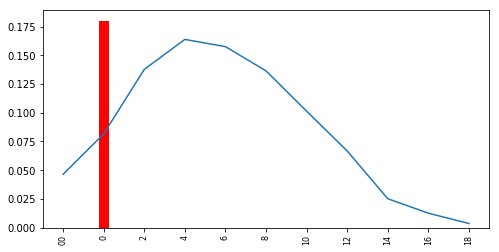

In [11]:
from random import randrange

ndx = randrange(len(X_test))
probs = model(X_test[ndx])
truth = torch.argmax(Y_test[ndx]).item()

plt.figure(figsize=(8, 4))
plt.plot(labels, probs.cpu().detach().numpy())
plt.bar(truth, 1.1*max(probs.cpu().detach().numpy()), width=.25, color='red')
plt.xticks(range(len(labels)), labels, fontsize=8, rotation='vertical');

In [12]:
y_pred = model(X_test).cpu().detach().numpy().argsort(axis=1)[:,:-4:-1]
y_pred

array([[4, 3, 2],
       [4, 3, 2],
       [3, 4, 2],
       ...,
       [3, 4, 2],
       [3, 4, 2],
       [3, 4, 2]])

In [13]:
y = np.argmax(Y_test.cpu().detach().numpy(), axis=2).flatten()

In [14]:
n = 0
for true, claims in zip(y, y_pred):
    predictions = ", ".join(labels[n] for n in claims[:3])
    print(labels[true], "->", predictions)
    if n > 100:
        break
    n += 1

6 -> 6, 4, 2
8 -> 6, 4, 2
14 -> 4, 6, 2
8 -> 4, 6, 8
12 -> 4, 6, 8
8 -> 4, 6, 2
8 -> 6, 4, 2
6 -> 4, 6, 2
2 -> 4, 6, 2
6 -> 6, 4, 8
4 -> 4, 6, 2
4 -> 4, 6, 8
8 -> 4, 6, 2
00 -> 4, 6, 2
6 -> 4, 6, 8
12 -> 4, 6, 2
8 -> 4, 6, 8
2 -> 4, 6, 8
2 -> 4, 6, 8
12 -> 4, 6, 8
8 -> 4, 6, 2
4 -> 4, 6, 8
8 -> 4, 6, 2
2 -> 4, 6, 2
8 -> 6, 4, 2
0 -> 4, 6, 2
00 -> 4, 6, 2
0 -> 4, 6, 2
12 -> 4, 6, 2
4 -> 6, 4, 2
2 -> 4, 6, 2
0 -> 4, 6, 2
12 -> 4, 6, 2
4 -> 4, 6, 2
2 -> 4, 6, 2
2 -> 4, 6, 2
00 -> 4, 6, 2
4 -> 4, 6, 8
8 -> 4, 6, 2
10 -> 4, 6, 2
6 -> 6, 4, 2
6 -> 4, 6, 2
6 -> 6, 4, 8
2 -> 6, 4, 2
10 -> 6, 4, 2
00 -> 6, 4, 8
8 -> 4, 6, 2
4 -> 4, 6, 2
00 -> 6, 4, 8
12 -> 4, 6, 2
2 -> 4, 6, 8
8 -> 4, 6, 2
2 -> 6, 4, 8
8 -> 4, 6, 2
0 -> 4, 6, 2
4 -> 6, 4, 2
0 -> 4, 6, 2
2 -> 6, 4, 8
12 -> 4, 6, 2
2 -> 4, 6, 8
4 -> 4, 6, 2
6 -> 4, 6, 2
4 -> 6, 4, 2
10 -> 4, 6, 2
4 -> 6, 4, 2
2 -> 4, 6, 8
4 -> 4, 6, 2
6 -> 6, 4, 2
2 -> 6, 4, 2
4 -> 4, 6, 2
00 -> 4, 6, 2
4 -> 4, 6, 2
6 -> 4, 6, 2
10 -> 4, 6, 8
10 -> 6, 4, 8
8 -> 6